# Reproduce Gary 1975 paper result of Alfven instabilities

<img src="figure/gary_1975_fig4.png" width=400>

In [1]:
import numpy as np
import scipy.optimize
from py_vlasov.util import zp, kzkp, list_to_complex, real_imag
from py_vlasov.wrapper import oblique_wrapper, disp_det, input_gen
from py_vlasov.transport_ratios import transport_ratios
from py_vlasov.follow_parameter import follow_k
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
mpl.rcParams['legend.fontsize'] = 14
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points
%matplotlib inline

In [2]:
def generate_k_arr(start_k, target_k, log_incrmt = None, lin_incrmt = None):
    assert log_incrmt or lin_incrmt
    if log_incrmt:
        n = int(np.log(target_k/start_k) / np.log(1 + log_incrmt))
        ret = np.arange(n + 1) * np.log(1 + log_incrmt)
        return np.exp(ret)  * start_k
    else:
        n = (target_k - start_k) / lin_incrmt
        if n - int(n) > 1 - 1e-5:
            n = int(n) + 1
        return start_k + np.arange(n + 1) * lin_incrmt

In [88]:
aol = np.sqrt(2.65e-8)
print('aol = ', aol)
tc_tp = 2
th_tc = 6
nc_np = 0.95
nh_np = 1 - nc_np
vc_va = 2.42
vh_va = -vc_va * nc_np / nh_np
print('vh_va = {0:.3g}'.format(vh_va))

betap = 0.25
theta = 80


t_list=[1., tc_tp, th_tc * tc_tp]
a_list=[1., 1., 1.]
n_list=[1., nc_np, nh_np] 
q_list=[1.,-1., -1.]
m_list=[1., 1./1836., 1./1836]
v_list=[0., vc_va, vh_va]
n = 6
method = 'pade'

k = 0.2
kz, kp = kzkp(k, theta)

param = [kz, kp, betap, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]

aol =  0.000162788205961
vh_va = -46


In [89]:
seed_freq = kz / np.sqrt(betap)
f = lambda wrel:\
    real_imag(oblique_wrapper(list_to_complex(wrel), kz, kp, betap,
                              t_list, a_list, n_list, q_list, \
                              m_list, v_list, method = method, n = n, \
                              aol=aol))
guess = seed_freq 
print('seed_freq = {0:.3g}'.format(guess))

wr, wi = scipy.optimize.fsolve(f, real_imag(guess))
print(wr)
print(wi)

seed_freq = 0.0695
0.0687445716234
-4.77380046564e-05


In [90]:
target_k = 2

# freq = follow_k(guess, target_k, param,
#                 log_incrmt = 0.05, incrmt_method = 'log')
freq = follow_k(guess, target_k, param,
                lin_incrmt = 0.02, incrmt_method = 'linear')               

In [91]:
k_arr = generate_k_arr(k, target_k, lin_incrmt=0.02)
# k_arr = generate_k_arr(k, target_k, log_incrmt=0.05)

In [92]:
wrel = np.array(freq[-1])

(-0.1, 0.01)

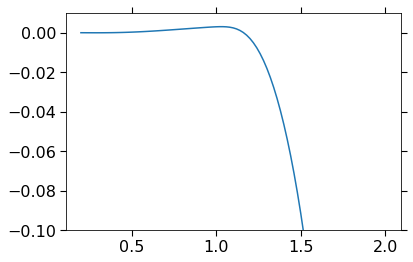

In [93]:
plt.plot(k_arr, wrel.imag)
plt.ylim([-.1,  .01])

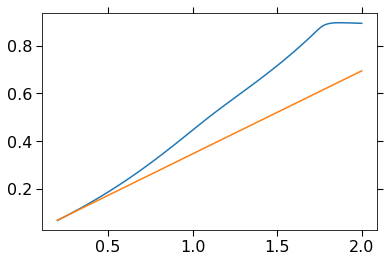

In [94]:
plt.plot(k_arr, wrel.real)
plt.plot(k_arr, k_arr * np.cos(np.deg2rad(theta))/np.sqrt(betap))
# plt.ylim([-1e-3,  .01])

# approximate KAW dispersion

In [95]:
from scipy.special import iv
from py_vlasov.util import zp

$$\left(\frac{\omega}{k_\parallel v_A}\right)^2 = \frac{1+k_\perp^2\rho_i^2 \left(T_e/T_i + 3/4\right)}{1+k_\perp^2\rho_i^2\frac{m_i}{m_e}\frac{1}{\beta_i}}$$

Lysak & Lotko 1996 Eq (4)

In [96]:
def kaw_f(kp, teti, betap):
    num = 1 + kp**2 * (teti + 0.75)
    denom = 1 + kp**2 / 1836 / betap
    return np.sqrt(num/denom)

def kaw_f2(kz, kp, teti, betap):
    b = kz**2 * 2/betap * kp**2 * (1 + teti)
    a = 1 + b
    a = 1/np.sqrt(a)
    b = np.sqrt(b)
    return a * b

In [97]:
# teti = tc_tp * nc_np + th_tc * tc_tp * nh_np
teti = tc_tp
kp_arr = k_arr * np.sin(np.deg2rad(theta))
kz_arr = k_arr * np.cos(np.deg2rad(theta))
w_kaw = np.array([kaw_f(kp, teti, betap) for kp in kp_arr])
# w_kaw_2 = np.array([kaw_f2(kz, kp, teti, betap) for kz, kp in zip(kz_arr, kp_arr)]) / np.sqrt(betap)
kzva = kz_arr / np.sqrt(betap)

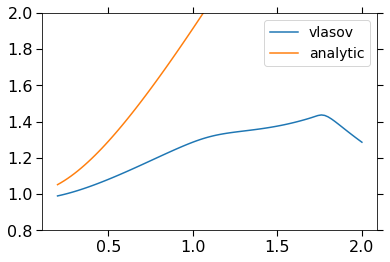

In [98]:
plt.plot(k_arr, wrel.real / kzva, label = 'vlasov')
plt.plot(k_arr, w_kaw, label = 'analytic')
plt.ylim([0.8, 2])
plt.legend()

## Conclusion: 
Approximated expression don't work well in the parameters of interest